##  <u> *Data Modelling*  </u>

In [ ]:
%run 3_EDA.ipynb

---

### <u>*Regression Modelling for severity as a Target Features*</u>


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor,XGBRFRegressor
import warnings
from catboost import CatBoostRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from hyperopt import fmin,tpe,STATUS_OK,Trials,hp


---

#### *B.1*<br> <u>*Basic Models Comparison :*</u>

##### *B.1.1*<br> <u>*Models :*</u>

In [3]:
models = {
                "Random Forest": RandomForestRegressor(random_state=41),
                "Gradient Boosting": GradientBoostingRegressor(random_state=41),
                "XGBRFRegressor":XGBRFRegressor(random_state=41),
                "CatBoosting Regressor": CatBoostRegressor(verbose=False,random_state=41),
                "AdaBoost Regressor": AdaBoostRegressor(random_state=41),
            }

##### *B.1.2*<br> <u>*Prepare Date :*</u>

* *Selecting The Most needed features*

In [4]:
df2=df.copy()
df2.drop(["clm"],axis=1,inplace=True)

In [8]:

x_severity=df2.drop("severity",axis=1)
y_severity=df2["severity"]

xtrain_full,xtest_full, ytrain, ytest = train_test_split(x_severity, y_severity, train_size=0.7, test_size=0.3,random_state=0)

numerical_cols = [col for col in xtrain_full.columns if xtrain_full[col].dtype in ['int64', 'float64']]
categorical_cols =[col for col in xtrain_full.columns if  xtrain_full[col].dtype == "object"]

my_cols = categorical_cols + numerical_cols
xtrain = xtrain_full[my_cols].copy()
xtest = xtest_full[my_cols].copy()

numerical_transformer = Pipeline(steps=[
    ("scaler",StandardScaler())
    ])


categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ("scaler",StandardScaler(with_mean=False))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

##### *B.1.3*<br> <u>*Apply Models :*</u>

In [9]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square


model_list = []
r2_list =[]
mae_list=[]
rmse_list=[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model =my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('melbourne_model', model)# or ('melbourne_model', RandomForestRegressor(random_state=0,n_estimators=50)) 
                             ])
    model.fit(xtrain, ytrain) 

    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)

    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    rmse_list.append(model_test_rmse)
    mae_list.append(model_test_mae)
    
    print('='*35)
    print('\n')



Random Forest
Model performance for Training set
- Root Mean Squared Error: 30.5000
- Mean Absolute Error: 0.6925
- R2 Score: 0.9992
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 104.6921
- Mean Absolute Error: 2.1112
- R2 Score: 0.9882


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 83.4574
- Mean Absolute Error: 2.0922
- R2 Score: 0.9925


Gradient Boosting
Model performance for Training set
- Root Mean Squared Error: 14.0659
- Mean Absolute Error: 2.0358
- R2 Score: 0.9998
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 69.8508
- Mean Absolute Error: 3.0245
- R2 Score: 0.9947


XGBRFRegressor
Model performance for Training set
- Root Mean Squared Error: 28.4728
- Mean Absolute Error: 3.8269
- R2 Score: 0.9993
-------

##### *B.1.4*<br> <u>*Best Model :*</u>

In [10]:
pd.DataFrame(list(zip(model_list,rmse_list,mae_list,r2_list)), 
             columns=['Model Name', 'rmse_Score','mae_Score','r2_Score']).sort_values(by=["mae_Score"],ascending=True)

,Model Name,rmse_Score,mae_Score,r2_Score
1,Decision Tree,83.457391,2.092204,0.992485
0,Random Forest,104.692078,2.111186,0.988174
2,Gradient Boosting,69.850830,3.024463,0.994736
4,CatBoosting Regressor,188.074665,4.308440,0.961835
3,XGBRFRegressor,111.133558,5.342124,0.986674
5,AdaBoost Regressor,586.056508,572.761144,0.629418


##### *B.1.5*<br> <u>*Apply Best Model :*</u>

In [11]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', GradientBoostingRegressor(random_state=41))
                             ])
my_pipeline.fit(xtrain, ytrain)
preds = my_pipeline.predict(xtest)
score = mean_absolute_error(ytest, preds)
print('MAE:', score)
score = r2_score(ytest, preds)*100
print(" Accuracy of the model is %.2f" %score)

MAE: 3.0244628663417967
 Accuracy of the model is 99.47


##### *B.1.6*<br> <u>*Visualize Best Model :*</u>

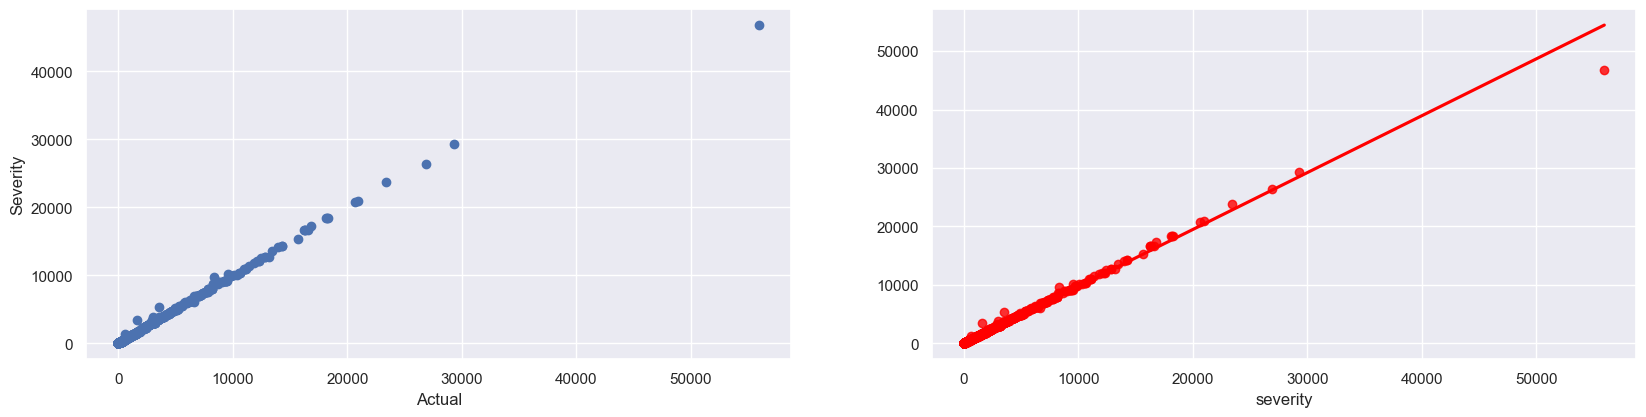

In [12]:
plt.subplot(221)
plt.scatter(ytest,preds);

plt.xlabel('Actual');
plt.ylabel('Severity');

plt.subplot(222)
sns.regplot(x=ytest,y=preds,ci=None,color ='red');

---

#### *B.2*<br> <u>*Hyperopt Models Comparison :*</u>

##### *B.2.1*<br> <u>*Create Spaces for each model :*</u>

In [15]:
space_rf = {
    'n_estimators': hp.choice('n_estimators', range(10, 200)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
    }


'''space_dt = {
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
    }'''

space_XGBRFRegressor = {
  'colsample_bynode': hp.uniform("colsample_bynode", 0.5,1), 
  "learning_rate": hp.uniform("learning_rate", 0, 1),
  'max_depth': hp.choice("max_depth", np.arange(1,20,1)),
  "num_parallel_tree": 100,
  "subsample": hp.uniform("subsample", 0.5,1)
}

space_catboost = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'depth': hp.choice('depth', range(1, 12)),
    'iterations': hp.choice('iterations', range(50, 200)),
}

space_adaboost = {
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
}

space_gradientboost = {
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.choice('max_depth', range(1, 12)),
}

##### *B.2.2*<br> <u>*Apply hyperopt :*</u>

In [18]:
def model_catboost(space_catboost):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostRegressor(
                                    learning_rate=float(space_catboost['learning_rate']),
                                    depth=int(space_catboost["depth"]),                                                       
                                    iterations=int(space_catboost['iterations'])
                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

#####################################################################

'''def model_rf(space_rf):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("RandomForestRegressor",RandomForestRegressor(
                                    n_estimators=int(space_rf['n_estimators']),
                                    max_depth=int(space_rf["max_depth"])                                                       
                                    #criterion=str(space_rf['criterion'])
                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            }   '''


#####################################################################

def model_gboost(space_gradientboost):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("GradientBoostingRegressor",GradientBoostingRegressor(
                                    n_estimators=int(space_gradientboost['n_estimators']),
                                    learning_rate=float(space_gradientboost["learning_rate"]),                                           
                                    max_depth=int(space_gradientboost['max_depth'])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

#####################################################################

def model_XGBRFRegressor(space_XGBRFRegressor):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("XGBRFRegressor",XGBRFRegressor(
                                    colsample_bynode=float(space_XGBRFRegressor['colsample_bynode']),
                                    learning_rate=float(space_XGBRFRegressor["learning_rate"]),                                           
                                    max_depth=int(space_XGBRFRegressor['max_depth']),
                                    num_parallel_tree=int(space_XGBRFRegressor['num_parallel_tree']),
                                    subsample=float(space_XGBRFRegressor['subsample'])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            }       

#####################################################################

def model_adaboost(space_adaboost):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("AdaBoostRegressor",AdaBoostRegressor(
                                    n_estimators=int(space_adaboost['n_estimators']),
                                    learning_rate=float(space_adaboost["learning_rate"])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

In [20]:
best_model_catboost = fmin(fn=model_catboost, space=space_catboost, algo=tpe.suggest, max_evals=10)
#best_model_rf = fmin(fn=model_rf, space=space_rf, algo=tpe.suggest, max_evals=10)
best_model_gboost = fmin(fn=model_gboost, space=space_gradientboost, algo=tpe.suggest, max_evals=10)
best_model_XGBRFRegressor = fmin(fn=model_XGBRFRegressor, space=space_XGBRFRegressor, algo=tpe.suggest, max_evals=10)
best_model_adaboost = fmin(fn=model_adaboost, space=space_adaboost, algo=tpe.suggest, max_evals=10)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

0:	learn: 878.6271711	total: 13.9ms	remaining: 1.69s
1:	learn: 729.1429586	total: 37.2ms	remaining: 2.25s
2:	learn: 614.9845861	total: 60.6ms	remaining: 2.42s
3:	learn: 517.7137115	total: 81.9ms	remaining: 2.44s
4:	learn: 442.9009593	total: 103ms	remaining: 2.44s
5:	learn: 373.4281433	total: 132ms	remaining: 2.56s
6:	learn: 317.9413738	total: 157ms	remaining: 2.6s
7:	learn: 274.0703747	total: 182ms	remaining: 2.61s
8:	learn: 240.5897077	total: 205ms	remaining: 2.59s
9:	learn: 209.2739736	total: 234ms	remaining: 2.65s
10:	learn: 182.8035193	total: 261ms	remaining: 2.65s
11:	learn: 162.7044217	total: 284ms	remaining: 2.63s
12:	learn: 146.8137852	total: 310ms	remaining: 2.62s
13:	learn: 131.0643951	total: 333ms	remaining: 2.59s
14:	learn: 120.5749062	total: 364ms	remaining: 2.62s
15:	learn: 111.4630408	total: 395ms	remaining: 2.64s
16:	learn: 102.4123731	total: 426ms	remaining: 2.66s
17:	learn: 95.1047166	total: 458ms	remaining: 2.67s
18:	learn: 88.8731341	total: 494ms	remaining: 2.7s
19:

##### *B.2.3*<br> <u>*hyperopt best params:*</u>

In [21]:
print("best_model_catboost",best_model_catboost)
#print("best_model_rf",best_model_rf)
print("best_model_gboost",best_model_gboost)
print("best_model_XGBRFRegressor",best_model_XGBRFRegressor)
print("best_model_adaboost",best_model_adaboost)

best_model_catboost {'depth': 7, 'iterations': 145, 'learning_rate': 0.1201883337199742}
best_model_gboost {'learning_rate': 0.07702678721790401, 'max_depth': 6, 'n_estimators': 120}
best_model_XGBRFRegressor {'colsample_bynode': 0.8286464572682684, 'learning_rate': 0.9734390569260418, 'max_depth': 15, 'subsample': 0.8195838706053304}
best_model_adaboost {'learning_rate': 0.07904245031407937, 'n_estimators': 124}


##### *B.2.4*<br> <u>*Apply hyperopt best params:*</u>

In [22]:
def model_catboost_best(best_model_catboost ):
    y_CatBoostRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostRegressor(
                                    learning_rate=float(best_model_catboost ['learning_rate']),
                                    depth=int(best_model_catboost ["depth"]),                                                       
                                    iterations=int(best_model_catboost ['iterations'])
                                    ))

                                    ]).fit(xtrain,ytrain)  
    
    y_pred = model_opt_best.predict(xtest)
    y_CatBoostRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_catboost_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_catboost_best is %.2f" %score)

#####################################################################

'''def model_rf_best(best_model_rf):
    y_RandomForestRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("RandomForestRegressor",RandomForestRegressor(
                                    n_estimators=int(best_model_rf['n_estimators']),
                                    max_depth=int(best_model_rf["max_depth"])                                                       
                                    #criterion=str(best_model_rf['criterion'])
                                    ))

                                    ]).fit(xtrain,ytrain)  
    
    y_pred = model_opt_best.predict(xtest)
    y_RandomForestRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_rf_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_rf_best is %.2f" %score) '''

#####################################################################

def model_gboost_best(best_model_gboost):
    y_gboost_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("GradientBoostingRegressor",GradientBoostingRegressor(
                                    n_estimators=int(best_model_gboost['n_estimators']),
                                    learning_rate=float(best_model_gboost["learning_rate"]),                                           
                                    max_depth=int(best_model_gboost['max_depth'])
                                    ))

                                    ]).fit(xtrain,ytrain)
    y_pred = model_opt_best.predict(xtest)
    y_gboost_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_gboost_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_gboost_best is %.2f" %score)

#####################################################################

def model_XGBRFRegressor_best(best_model_XGBRFRegressor):
    y_XGBRFRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("XGBRFRegressor",XGBRFRegressor(
                                    colsample_bynode=float(best_model_XGBRFRegressor['colsample_bynode']),
                                    learning_rate=float(best_model_XGBRFRegressor["learning_rate"]),                                           
                                    max_depth=int(best_model_XGBRFRegressor['max_depth']),
                                    # num_parallel_tree=int(best_model_XGBRFRegressor['num_parallel_tree']),
                                    subsample=float(best_model_XGBRFRegressor['subsample'])
                                    ))

                                    ]).fit(xtrain,ytrain)
    
    y_pred = model_opt_best.predict(xtest)
    y_XGBRFRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_XGBRFRegressor_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_XGBRFRegressor_best is %.2f" %score)

#####################################################################

def model_adaboost_best(best_model_adaboost):
    y_adaboost_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("AdaBoostRegressor",AdaBoostRegressor(
                                    n_estimators=int(best_model_adaboost['n_estimators']),
                                    learning_rate=float(best_model_adaboost["learning_rate"])
                                    ))

                                    ]).fit(xtrain,ytrain)
    
    y_pred = model_opt_best.predict(xtest)
    y_adaboost_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_adaboost_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_adaboost_best is %.2f" %score)

##### *B.2.5*<br> <u>*Determine the best model and hyperopt best params:*</u>

In [23]:

model_catboost_best(best_model_catboost)

0:	learn: 945.7018053	total: 50.8ms	remaining: 7.31s
1:	learn: 850.4120294	total: 68.1ms	remaining: 4.87s
2:	learn: 762.0663208	total: 89.7ms	remaining: 4.25s
3:	learn: 690.0045934	total: 116ms	remaining: 4.07s
4:	learn: 618.6885585	total: 137ms	remaining: 3.83s
5:	learn: 555.7962445	total: 165ms	remaining: 3.81s
6:	learn: 506.1210987	total: 195ms	remaining: 3.85s
7:	learn: 458.1608767	total: 223ms	remaining: 3.81s
8:	learn: 415.5166646	total: 244ms	remaining: 3.69s
9:	learn: 377.8072183	total: 261ms	remaining: 3.52s
10:	learn: 345.4286172	total: 276ms	remaining: 3.36s
11:	learn: 313.2208055	total: 292ms	remaining: 3.24s
12:	learn: 286.3925739	total: 307ms	remaining: 3.11s
13:	learn: 262.4546467	total: 321ms	remaining: 3s
14:	learn: 240.5644087	total: 336ms	remaining: 2.91s
15:	learn: 221.6947901	total: 350ms	remaining: 2.82s
16:	learn: 204.7847384	total: 364ms	remaining: 2.74s
17:	learn: 189.0754227	total: 378ms	remaining: 2.67s
18:	learn: 175.8929352	total: 391ms	remaining: 2.59s
19:

In [24]:
#model_rf_best(best_model_rf)

In [25]:
model_gboost_best(best_model_gboost)


model_gboost_best MAE: 1.6045338083590175
 Accuracy of the model_gboost_best is 99.44


In [26]:
model_XGBRFRegressor_best(best_model_XGBRFRegressor)


model_XGBRFRegressor_best MAE: 4.482818446179525
 Accuracy of the model_XGBRFRegressor_best is 98.73


In [27]:
model_adaboost_best(best_model_adaboost)

model_adaboost_best MAE: 63.97972162353525
 Accuracy of the model_adaboost_best is 96.83


In [28]:
# best_model_gboost {'learning_rate': 0.07702678721790401, 'max_depth': 6, 'n_estimators': 120}

my_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(
            learning_rate= 0.07702678721790401,
            max_depth= 6,
            n_estimators= 120))
            ])
                                    

my_pipeline.fit(xtrain, ytrain)
preds = my_pipeline.predict(xtest)
score = mean_absolute_error(ytest, preds)
print('MAE:', score)
score = r2_score(ytest, preds)*100
print(" Accuracy of the model is %.2f" %score)

MAE: 1.5999080052343875
 Accuracy of the model is 99.45


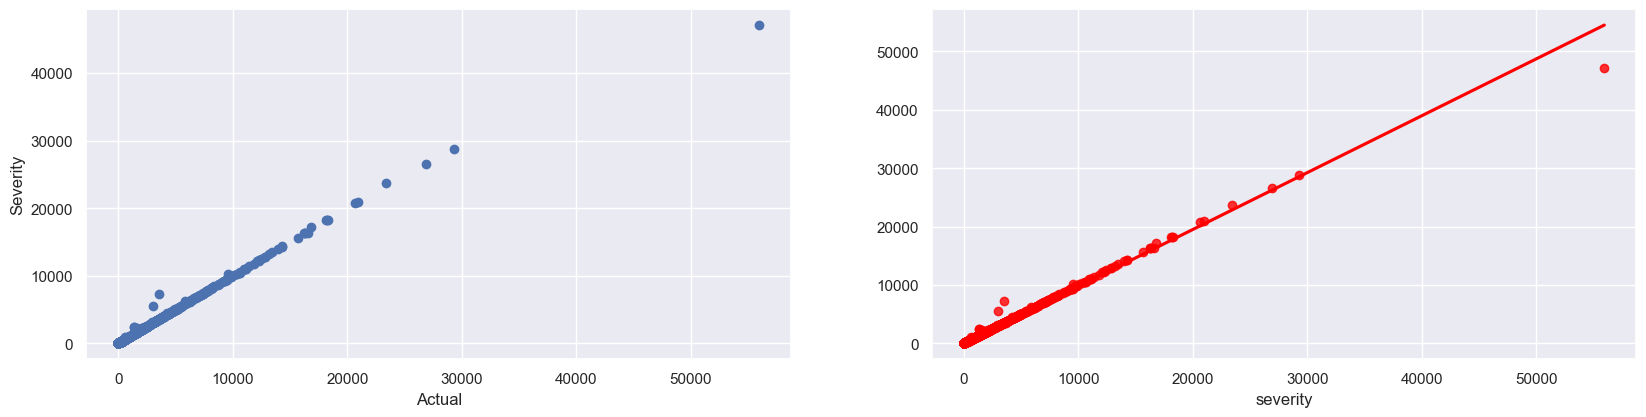

In [29]:
plt.subplot(221)
plt.scatter(ytest,preds);

plt.xlabel('Actual');
plt.ylabel('Severity');

plt.subplot(222)
sns.regplot(x=ytest,y=preds,ci=None,color ='red');

---

In [30]:
import pickle
with open ("severity_final_model.pkl","wb") as f:
    pickle.dump(my_pipeline,f)


---